In [1]:
from dotenv import load_dotenv
load_dotenv("./.env")

True

In [2]:
from pydantic_settings import BaseSettings

class ModelConfig(BaseSettings):
    GEMINI_API_KEY: str
    MODEL_NAME: str
    TEMPERATURE: float

In [3]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

In [4]:
class GeminiChatModel(ChatGoogleGenerativeAI):
    """Custom Gemini Chat Model"""

    def __init__(self, config: ModelConfig):
        super().__init__(
            model=config.MODEL_NAME,
            temperature=config.TEMPERATURE,
            api_key=config.GEMINI_API_KEY,
            
        )

In [ ]:
from pydantic import BaseModel
from typing import Optional

class FilingState(BaseModel):
    documents: list
    query: str
    context: str = ""
    answer: str = ""
    financials: dict = {}
    complaince: dict = {}
    risks: list = []

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

In [17]:
def ingestion_node(state: FilingState) -> FilingState:
    """Ingest documents and update state."""
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    state.documents = splitter.split_documents(state.documents)
    return state

def vectorstore_node(state: FilingState) -> FilingState:
    """Vectorstore node using Chroma for retrieval."""
    try:
        # Use GoogleGenerativeAIEmbeddings for embedding
        embedder = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=ModelConfig().GEMINI_API_KEY)
        # Create Chroma vectorstore from documents
        vectorstore = Chroma.from_documents(state.documents, embedder)
        # Retrieve relevant documents using similarity search
        relevant_docs = vectorstore.similarity_search(state.query, k=3)
        # Concatenate page_content for context
        state.context = " ".join([doc.page_content for doc in relevant_docs])
        return state
    except Exception as e:
        print(f"Error in vectorstore_node: {e}")
        # Fallback: use all document content
        state.context = " ".join([doc.page_content for doc in state.documents])
        return state

def router_node(state: FilingState) -> FilingState:
    try:
        llm = GeminiChatModel(ModelConfig())
        routing_prompt = f"""
        Classify the following query into one of the categories: [financials, compliance, risks, qa]
        Query: {state.query}
        Respond with just the category name.
        """
        response = llm.invoke([{"role": "user", "content": routing_prompt}])
        category = response.content.strip().lower()
        if category not in ["financials", "compliance", "risks", "qa"]:
            category = "qa"
        state.answer = category
        return state
    except Exception as e:
        print(f"Error in router_node: {e}")
        # Default to qa if routing fails
        state.answer = "qa"
        return state

def qa_node(state: FilingState) -> FilingState:
    try:
        llm = GeminiChatModel(ModelConfig())
        qa_prompt = f"""
        You are a financial analyst. Use the following context to answer the query.
        Context: {state.context[:2000]}  
        Query: {state.query}
        Provide a clear and concise answer.
        """
        response = llm.invoke([{"role": "user", "content": qa_prompt}])
        state.answer = response.content.strip()
        return state
    except Exception as e:
        print(f"Error in qa_node: {e}")
        state.answer = f"Error processing query: {str(e)}"
        return state

def financials_node(state: FilingState) -> FilingState:
    try:
        llm = GeminiChatModel(ModelConfig())
        financials_prompt = f"""
        Extract key financial metrics from the following context and return them as a JSON object.
        Include metrics like revenue, profit, growth rates, margins, etc.
        
        Context: {state.context[:2000]}
        
        Return only valid JSON format like:
        {{"revenue": "value", "profit": "value", "growth": "value"}}
        """
        response = llm.invoke([{"role": "user", "content": financials_prompt}])
        
        # Try to parse JSON response
        import json
        try:
            state.financials = json.loads(response.content.strip())
        except json.JSONDecodeError:
            # If JSON parsing fails, extract key numbers manually
            content = response.content.strip()
            state.financials = {"raw_response": content}
        
        return state
    except Exception as e:
        print(f"Error in financials_node: {e}")
        state.financials = {"error": str(e)}
        return state

def compliance_node(state: FilingState) -> FilingState:
    try:
        llm = GeminiChatModel(ModelConfig())
        compliance_prompt = f"""
        Identify compliance issues from the following context and return as JSON.
        Context: {state.context[:2000]}
        """
        response = llm.invoke([{"role": "user", "content": compliance_prompt}])
        
        import json
        try:
            state.complaince = json.loads(response.content.strip())
        except json.JSONDecodeError:
            state.complaince = {"raw_response": response.content.strip()}
        return state
    except Exception as e:
        print(f"Error in compliance_node: {e}")
        state.complaince = {"error": str(e)}
        return state

def risks_node(state: FilingState) -> FilingState:
    try:
        llm = GeminiChatModel(ModelConfig())
        risks_prompt = f"""
        List potential risks mentioned in the following context.
        Context: {state.context[:2000]}
        Return as a simple list.
        """
        response = llm.invoke([{"role": "user", "content": risks_prompt}])
        state.risks = [response.content.strip()]
        return state
    except Exception as e:
        print(f"Error in risks_node: {e}")
        state.risks = [f"Error: {str(e)}"]
        return state

In [18]:
from langgraph.graph import StateGraph, START, END

In [19]:
graph = StateGraph(FilingState)

graph.add_node("ingestion", ingestion_node)
graph.add_node("vectorstore", vectorstore_node)
graph.add_node("router", router_node)
graph.add_node("qa", qa_node)
graph.add_node("financials", financials_node)
graph.add_node("compliance", compliance_node)
graph.add_node("risks", risks_node)

graph.add_edge(START, "ingestion")
graph.add_edge("ingestion", "vectorstore")
graph.add_edge("vectorstore", "router")

graph.add_conditional_edges("router", 
                            lambda state: state.answer, 
                            {
                                "qa": "qa",
                                "financials": "financials",
                                "compliance": "compliance",
                                "risks": "risks"
                            }
)

graph.add_edge("qa", END)
graph.add_edge("financials", END)
graph.add_edge("compliance", END)
graph.add_edge("risks", END)

app = graph.compile()

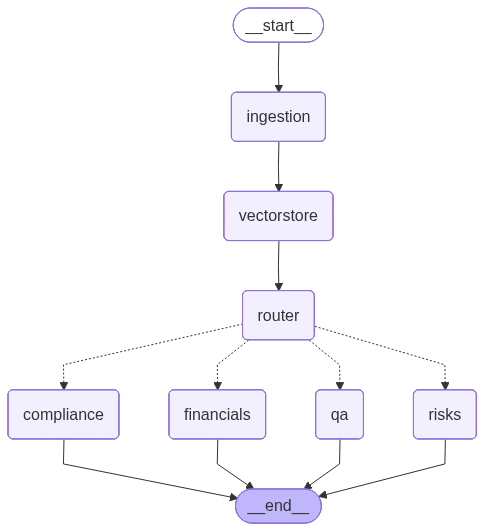

In [21]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
from langchain_core.documents import Document

docs = [
    Document(page_content="""
TE
ST
O
T
/N
L
EA
RExecutive Summary (Fictional)
Company: BankingCo Finance Ltd.
Sector: Banking & Financial Services
Filing Type: Quarterly Report / Abridged (Fictional)
Generated on: 2025-09-17
Overview: This is a synthetic executive summary intended for testing extraction pipelines.
Key Highlights (fictional):
Total Revenue (FY): INR 2,450,000,000
Net Profit (FY): INR 78,000,000
YoY Growth (Revenue): 12.5%
EBITDA Margin: 8.57%
G
N
R
FO
I
T
S
E
T
O
YMetric
FY2023FY2024FY2025
Interest Income900,000,0001,000,000,0001,200,000,000
Interest Expense300,000,000330,000,000400,000,000
Net Interest Income600,000,000670,000,000800,000,000
Provision for NPAs35,000,00040,000,00045,000,000
Net Profit120,000,000140,000,000160,000,000
=== THIS DATA IS FICTIONAL. FOR TESTING/DEVELOPMENT ONLY ===Independent Auditor's Report (Mock)
To the Members of BankingCo Finance Ltd. (Fictional)
Opinion:
In our opinion, except for the matter described in the Basis for Qualified Opinion paragraph, the
accompanying financial statements present fairly, in all material respects, the financial position of the Company.
Basis for Opinion:
This is a mock auditor's opinion included for testing and does not represent a real audit.
Key Audit Matters (Mock):
- Revenue recognition and cut-off
- Valuation of inventory / provisions
This report is fictional and for application testing only.
Place: Fictional City
Date: 2025-09-17
Mock Auditor: Deloitte Simulation & Co. (Not real)Annexure A: Shareholding Pattern (Mock)
CategoryNo. of ShareholdersNo. of SharesPercentage (%)
Promoters355,000,00055.0
Public (Institutions)1020,000,00020.0
Public (Retail)150020,000,00020.0
ESOP/Employee Trust15,000,0005.0Machine-Readable Metadata (Fictional)
{"company": "BankingCo Finance Ltd.", "cin": "U11111BK2025PLC000002", "sector": "Banking & Financial Services", "filing_type": "Quart
F
-
R
O
R
T
I
A
I
N
G
N
O
Y
L
""")
]

In [23]:
state = FilingState(documents=docs, query="Summarize financial stateemts")
result = app.invoke(state)
print("Route taken:", result["answer"])
print("Financials:", result["financials"])
print("Full result keys:", list(result.keys()))

Route taken: financials
Financials: {'raw_response': '```json\n{\n  "revenue": "INR 2,450,000,000",\n  "profit": "INR 78,000,000",\n  "growth_revenue_yoy": "12.5%",\n  "ebitda_margin": "8.57%"\n}\n```'}
Full result keys: ['documents', 'query', 'context', 'answer', 'financials', 'complaince', 'risks', 'route']


In [ ]:
# Test different types of queries to see routing in action
test_queries = [
    # "What are the main risks facing the company?",
    "Are there any compliance violations mentioned?", 
    # "Who are the main shareholders?",
    # "What was the revenue growth last year?"
]

for query in test_queries:
    print(f"\n--- Testing query: '{query}' ---")
    state = FilingState(documents=docs, query=query)
    result = app.invoke(state)
    print(f"Route: {result['answer']}")
    if result['answer'] == 'financials':
        print(f"Financials: {result['financials']}")
    elif result['answer'] == 'risks':
        print(f"Risks: {result['risks']}")
    elif result['answer'] == 'compliance':
        print(f"Compliance: {result['complaince']}")
    else:
        print(f"Answer: {result['answer']}")


--- Testing query: 'What are the main risks facing the company?' ---
Route: risks
Risks: ['Here are the potential risks mentioned in the context:\n\n*   A matter described in the Basis for Qualified Opinion paragraph (which led to a qualified opinion).\n*   Revenue recognition and cut-off (identified as a Key Audit Matter).\n*   Valuation of inventory / provisions (identified as a Key Audit Matter).']

--- Testing query: 'Are there any compliance violations mentioned?' ---
Route: risks
Risks: ['Here are the potential risks mentioned in the context:\n\n*   A matter described in the Basis for Qualified Opinion paragraph (which led to a qualified opinion).\n*   Revenue recognition and cut-off (identified as a Key Audit Matter).\n*   Valuation of inventory / provisions (identified as a Key Audit Matter).']

--- Testing query: 'Are there any compliance violations mentioned?' ---
Route: compliance
Compliance: {'raw_response': '```json\n{\n  "compliance_issues": [\n    {\n      "issue_id": "